# Test ULMFiT + sentencepiece arxiv categories large classifier

## Load model and data

In [1]:
%cd ~/paperswithcode/paper-extractor

/home/ubuntu/paperswithcode/paper-extractor


In [2]:
import pandas as pd, numpy as np
from pathlib import Path
import pickle

DATA_PATH = Path("notebooks/shared-notebooks/arxiv-class")
TRAIN_PATH = DATA_PATH / "arxiv-tag-classifier-data.json"
TEST_PATH = DATA_PATH / "classifier.tsv"

In [3]:
test_df = pd.read_pickle(DATA_PATH / "test_df.pkl.gz")
test = pd.read_csv(TEST_PATH, sep="\t", header=None, names=["arxiv_id", "tags", "output"])

In [4]:
# keep only test papers for which we have abstracts

import re
aidv_re = re.compile("(v\d+)?$")
test["no_version"] = test.arxiv_id.str.replace(aidv_re, "")
test = test.drop_duplicates(["no_version"])

test_df = test_df[test_df.arxiv_id.isin(test.no_version)]
test_df = test_df.drop_duplicates(["arxiv_id"])

test = test[test.no_version.isin(test_df.arxiv_id)]

test = test.sort_values("no_version")
test_df = test_df.sort_values("arxiv_id")

In [6]:
from fastai.text import *

BASE_DIR = Path("./models/ulmfit_baseline")
VOCAB_PATH = BASE_DIR / "data_lm_export_vocab.pkl"
MODELS_PATH = DATA_PATH / "models"

processor = SPProcessor(sp_model=BASE_DIR / "tmp" / "spm.model", sp_vocab=BASE_DIR / "tmp" / "spm.vocab", n_cpus=4, mark_fields=True)
vocab = Vocab.load(VOCAB_PATH)


In [26]:
data_clas = load_data(MODELS_PATH, "data_clas_abs.pkl")

In [7]:
lin_ftrs = [len(data_clas.valid_dl.y.classes) * 2] # 352
learn = text_classifier_learner(data_clas, AWD_LSTM, lin_ftrs=lin_ftrs)

In [8]:
learn.load("arxiv_large_class_sp30k_1_1_ft_1_1_6_abstracts.pkl");

In [9]:
text_cols = ["title", "abstract"]
test_tl = TextList.from_df(test_df, MODELS_PATH, cols=text_cols, processor=processor)

learn.data.add_test(test_tl)

## Get predictions

In [7]:
def dump_test_preds(preds, classes, name, desc, info=None):
    with (DATA_PATH / "preds" / "test" / f"{name}.pkl").open("wb") as f:
        pickle.dump((preds, classes, name, desc, info), f)

def load_test_preds(name):
    with (DATA_PATH / "preds" / "test" / f"{name}.pkl").open("rb") as f:
        preds, classes, name, desc, info = pickle.load(f)
    return preds, classes, name, desc, info

In [8]:
def get_test_stats(test_preds, test_labels, threshold=0.5):
    y_true = test_labels
    if threshold <= 1.0:
        y_pred = test_preds.cpu().numpy() > threshold
    else:
        idx = test_preds.cpu().argmax(1, keepdim=True)
        one_hot = torch.FloatTensor(probs.shape)
        y_pred = test_preds.cpu().numpy().argmax()
    return precision_score(y_true, y_pred, average='micro'), recall_score(y_true, y_pred, average='micro')

In [23]:
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import json

def get_cm(preds, threshold=0.5):
    y_true = preds[1].cpu().numpy() > 0.5
    y_pred = preds[0].cpu().numpy() > threshold
    return multilabel_confusion_matrix(y_true, y_pred)

def get_test_stats(test_preds, test_labels, threshold=0.5):
    y_true = test_labels
    if isinstance(threshold, str) and threshold.startswith("top-"):
        topk = int(threshold[4:])
        indices = test_preds.cpu().topk(topk, dim=1)[1]
        y_pred = torch.zeros_like(test_preds)
        y_pred.scatter_(1, indices, 1)
    else:
        y_pred = test_preds.cpu().numpy() > threshold

    stats = {}
    stats['micro p'] = precision_score(y_true, y_pred, average='micro')
    stats['micro r'] = recall_score(y_true, y_pred, average='micro')
    stats['micro f1'] = f1_score(y_true, y_pred, average='micro')
    stats['macro p'] = precision_score(y_true, y_pred, average='macro')
    stats['macro r'] = recall_score(y_true, y_pred, average='macro')
    stats['macro f1'] = f1_score(y_true, y_pred, average='macro')
    cm = multilabel_confusion_matrix(y_true, y_pred)
    return stats, cm
    
def get_test_labels(test_df, c2i):
    out = np.zeros((len(test_df), len(c2i)), dtype=np.int8)
    for i, (_, row) in enumerate(test_df.iterrows()):
        for x in row.categories.split(' '):
            out[i, c2i[x]] = 1
    return out

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def get_current_arxiv_preds(test, c2i):
    out = np.zeros((len(test), len(c2i)), dtype=np.float)
    for i, (_, row) in enumerate(test.iterrows()):
        for x in json.loads(row.output)['classifier']:
            category = x['category']
            pred = sigmoid(float(x['logodds']))
            out[i, c2i[category]] = pred
    return torch.FloatTensor(out)

In [13]:
test_preds, _ = learn.get_preds(DatasetType.Test, ordered=True)

In [14]:
current_arxiv_preds = get_current_arxiv_preds(test, data_clas.valid_ds.y.c2i)

In [27]:
test_labels = get_test_labels(test_df, data_clas.valid_ds.y.c2i)

In [13]:
mixes = {
    'avg': lambda a,b: (a+b)/2,
    'max': lambda a,b: torch.max(a, b),
    'geom': lambda a,b: (a * b).sqrt(),
    'min': lambda a,b: torch.min(a,b),
    'l2': lambda a,b: (a*a+b*b).sqrt(),
}

In [76]:
test.tail()

,arxiv_id,tags,output,no_version
4625,math/0306214v2,math.DS math-ph math.MG math.MP,"{""flags"":{},""classifier"":[{""topwords"":[{""recur...",math/0306214
92,math/0603190v5,math.DG gr-qc math-ph math.MP,"{""flags"":{},""classifier"":[{""topwords"":[{""loren...",math/0603190
6684,math/0609574v2,math.CO,"{""flags"":{},""classifier"":[{""topwords"":[{""graph...",math/0609574
1984,math/0702601v4,math.MG math.CO,"{""flags"":{},""classifier"":[{""topwords"":[{""noneu...",math/0702601
7061,quant-ph/0701168v3,quant-ph cs.CR cs.IT math.IT,"{""flags"":{},""classifier"":[{""topwords"":[{""secur...",quant-ph/0701168


In [78]:
len(test)

9774

In [96]:
for row in test_labels[-5:]:
    tags = [data_clas.valid_ds.y.classes[i] for i, p in enumerate(row) if p > 0.125]
    print(', '.join(tags))

math-ph, math.DS, math.MG, math.MP
gr-qc, math-ph, math.DG, math.MP
math.CO
math.CO, math.MG
cs.CR, cs.IT, math.IT, quant-ph


In [150]:
# 0.218
for row in all_preds['ulmfit']['preds'][-5:]:
    tags = [(data_clas.valid_ds.y.classes[i],p) for i, p in enumerate(row) if p > 0.0]
    tags = sorted(tags, key=lambda x: -x[1])[0:5]
    print(', '.join([t[0] for t in tags]))

math.DS, math.MG, math.GT, math-ph, math.MP
gr-qc, math.DG, math-ph, math.MP, hep-th
math.CO, cs.DM, math.AC, math.MG, math.AT
math.MG, math.CO, math.DG, math.GT, math.CA
quant-ph, cs.CR, cs.IT, math.IT, cs.NI


In [140]:
[[data_clas.valid_ds.y.classes[i] for i, p in enumerate(row) if p > 0.0169] for row in all_preds['ulmfit']['preds'][-5:]]

[['math-ph', 'math.DS', 'math.GT', 'math.MG', 'math.MP'],
 ['gr-qc',
  'hep-th',
  'math-ph',
  'math.DG',
  'math.GT',
  'math.MG',
  'math.MP',
  'physics.gen-ph'],
 ['cs.DM', 'math.CO'],
 ['cs.CG',
  'math.AG',
  'math.AT',
  'math.CA',
  'math.CO',
  'math.CV',
  'math.DG',
  'math.FA',
  'math.GR',
  'math.GT',
  'math.MG'],
 ['cs.CR', 'cs.IT', 'math.IT', 'quant-ph']]

In [151]:
x = get_test_stats(all_preds['ulmfit']['preds'][-5:], test_labels[-5:], "top-5")[0]
x['micro p'], x['micro r']

(0.6, 1.0)

In [83]:
all_preds['ulmfit']['preds'][-5:] > 0.5

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [74]:
test_labels

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=int8)

In [17]:
np.linspace(0.01, 1.0)

array([0.01    , 0.030204, 0.050408, 0.070612, 0.090816, 0.11102 , 0.131224, 0.151429, 0.171633, 0.191837, 0.212041,
       0.232245, 0.252449, 0.272653, 0.292857, 0.313061, 0.333265, 0.353469, 0.373673, 0.393878, 0.414082, 0.434286,
       0.45449 , 0.474694, 0.494898, 0.515102, 0.535306, 0.55551 , 0.575714, 0.595918, 0.616122, 0.636327, 0.656531,
       0.676735, 0.696939, 0.717143, 0.737347, 0.757551, 0.777755, 0.797959, 0.818163, 0.838367, 0.858571, 0.878776,
       0.89898 , 0.919184, 0.939388, 0.959592, 0.979796, 1.      ])

In [15]:
learn2 = text_classifier_learner(data_clas, AWD_LSTM)
learn2.load("arxiv_class_sp30k_1_1_6_abstracts.pkl");
notune_test_preds, _ = learn2.get_preds(DatasetType.Test, ordered=True)

In [16]:
learn3 = text_classifier_learner(data_clas, AWD_LSTM, lin_ftrs=lin_ftrs)
learn3.load("arxiv_large_class_sp30k_1_1_ft_1_1_6_pos_weight_1_abstracts.pkl");
pw_test_preds, _ = learn3.get_preds(DatasetType.Test, ordered=True)

In [28]:
dump_test_preds(test_preds, data_clas.valid_ds.y.classes, "ulmfit",
               """predictions of 'arxiv_large_class_sp30k_1_1_ft_1_1_6_abstracts.pkl'""",
               info={'model': "arxiv_large_class_sp30k_1_1_ft_1_1_6_abstracts.pkl"})

dump_test_preds(notune_test_preds, data_clas.valid_ds.y.classes, "ulmfit-noft",
               """predictions of 'arxiv_class_sp30k_1_1_6_abstracts.pkl'""",
               info={'model': "arxiv_class_sp30k_1_1_6_abstracts.pkl"})

dump_test_preds(pw_test_preds, data_clas.valid_ds.y.classes, "ulmfit-pw",
               """predictions of 'arxiv_large_class_sp30k_1_1_ft_1_1_6_pos_weight_1_abstracts.pkl'""",
               info={'model': "arxiv_large_class_sp30k_1_1_ft_1_1_6_pos_weight_1_abstracts.pkl"})

dump_test_preds(current_arxiv_preds, data_clas.valid_ds.y.classes, "arxiv",
               """predictions of arxiv classifier""")

In [10]:
def get_preds(path):
    classes = None
    all_preds = {}
    for preds_file in sorted(Path(path).glob("*.pkl")):
        print(preds_file)
        preds, clss, name, desc, info = load_test_preds(preds_file.stem)
        if classes is not None and classes != clss:
            print(f"[ERROR] {preds_file} has different classes")
        classes = clss
        all_preds[name] = dict(
            preds=preds,
            name=name,
            desc=desc
        )
    return all_preds

In [11]:
all_preds = get_preds(DATA_PATH / "preds" / "test")

notebooks/shared-notebooks/arxiv-class/preds/test/arxiv.pkl
notebooks/shared-notebooks/arxiv-class/preds/test/nbsvm.pkl
notebooks/shared-notebooks/arxiv-class/preds/test/ulmfit-noft.pkl
notebooks/shared-notebooks/arxiv-class/preds/test/ulmfit-pw.pkl
notebooks/shared-notebooks/arxiv-class/preds/test/ulmfit.pkl


In [14]:
all_preds['l2'] = dict(
    preds=mixes['l2'](all_preds['ulmfit']['preds'], all_preds['arxiv']['preds']),
    name='l2'
)

In [72]:
test_stats_all_176 = test_stats_all

In [46]:
test_stats_all = []
# for threshold in [0.125, 0.25, 0.5, 0.75, 0.95, "top-1"]:
for threshold in list(np.linspace(0.01, 1.0)) + ["top-1", "top-5"]: #, "top-2", "top-3", "top-4", "top-5"]:
    for p in all_preds.values():
        preds = torch.FloatTensor(p['preds'])
        test_stats, test_cm = get_test_stats(preds[:, indices15], test_labels[:, indices15], threshold)
        test_stats['threshold'] = threshold
        test_stats['classifier'] = p['name']
        test_stats_all.append(test_stats)
    
#     for n, f in mixes.items():
#         mixed_preds = f(test_preds, current_arxiv_preds)
#         test_stats, test_cm = get_test_stats(mixed_preds, test_labels, threshold)
#         test_stats['threshold'] = threshold
#         test_stats['classifier'] = n
#         test_stats_all.append(test_stats)

In [33]:
indices15 = np.array([data_clas.valid_ds.y.c2i[c] for c in classes15])

In [47]:
stats_df = pd.DataFrame(test_stats_all)

In [41]:
stats_df.style.highlight_max()

,micro p,micro r,micro f1,macro p,macro r,macro f1,threshold,classifier
0,0.499261,0.820753,0.620857,0.389576,0.607926,0.463603,0.125,ulmfit
1,0.275219,0.837,0.414232,0.208787,0.675549,0.303395,0.125,arxiv
2,0.278332,0.897776,0.424927,0.219682,0.71832,0.319131,0.125,mixed
3,0.621156,0.731871,0.671984,0.477183,0.500993,0.474138,0.25,ulmfit
4,0.275219,0.837,0.414232,0.208787,0.675549,0.303395,0.25,arxiv
5,0.286789,0.870382,0.431424,0.227397,0.696979,0.322403,0.25,mixed
6,0.760811,0.585236,0.661572,0.57237,0.370926,0.42532,0.5,ulmfit
7,0.286006,0.815061,0.423429,0.219256,0.658933,0.310304,0.5,arxiv
8,0.752827,0.607886,0.672637,0.558522,0.399716,0.444758,0.5,mixed
9,0.875,0.414231,0.562276,0.589177,0.245683,0.324747,0.75,ulmfit


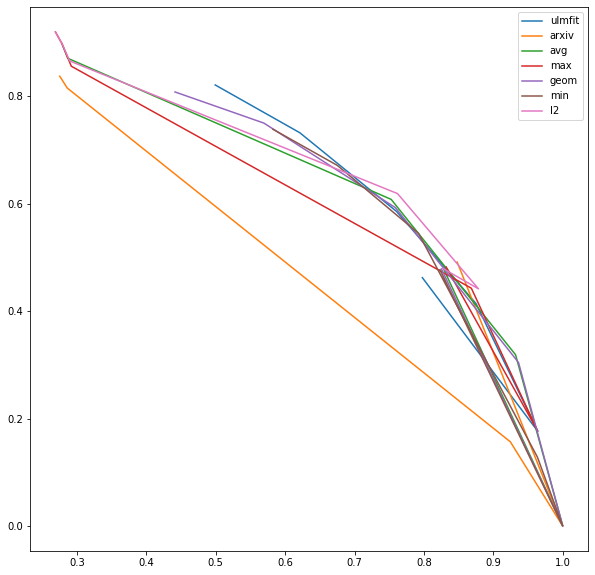

In [52]:
stat = "micro"
classifiers = ["ulmfit", "arxiv"] + list(mixes.keys())
plt.figure(figsize=(10,10))
for cls in classifiers:
    x = stats_df[stats_df.classifier == cls][f"{stat} p"]
    y = stats_df[stats_df.classifier == cls][f"{stat} r"]
    plt.plot(x,y);
plt.legend(classifiers)

In [70]:
def plot_pr(stat="micro", classifiers = ["ulmfit", "ulmfit-noft", "arxiv", "l2"]):
#     stat = "micro"
#     classifiers = ["ulmfit", "ulmfit-noft", "arxiv"] + ["l2"]#+ list(mixes.keys())
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    topks = 2
    markers = ['*', 'o'] #, '*', 's', 'h']
    for cls in classifiers:
        x = stats_df[stats_df.classifier == cls][f"{stat} p"]
        y = stats_df[stats_df.classifier == cls][f"{stat} r"]
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(x[:-topks-1],y[:-topks-1], color=color, label=cls)
        for i, marker in zip(range(1, topks+1), markers):
            plt.plot([x.values[-i]], [y.values[-i]], marker, color=color)
    plt.legend()
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel(f"{stat} precision")
    plt.ylabel(f"{stat} recall")
    plt.xticks(np.linspace(0.0, 1.0, num=21))
    plt.yticks(np.linspace(0.0, 1.0, num=21))

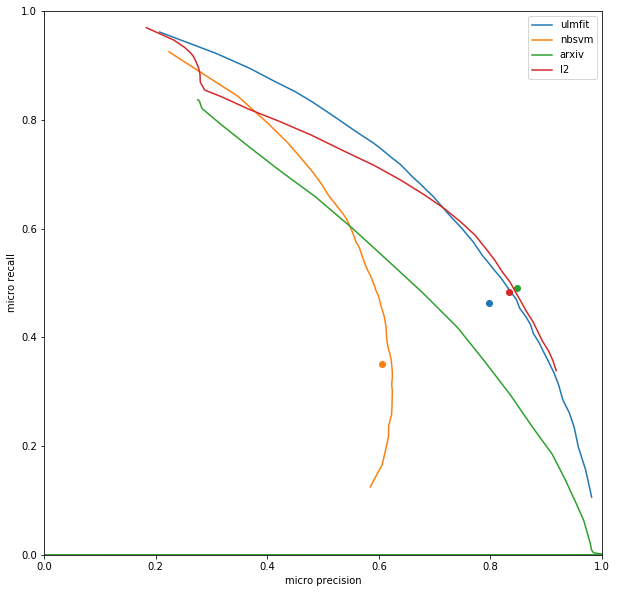

In [56]:
plot_pr("micro", ["ulmfit", "nbsvm", "arxiv", "l2"])

In [50]:
stats_df[stats_df.threshold.isin(["top-1", "top-5"])]

,classifier,macro f1,macro p,macro r,micro f1,micro p,micro r,threshold
300,arxiv,0.504226,0.742235,0.409136,0.622119,0.847759,0.491343,top-1
301,nbsvm,0.484344,0.648219,0.410647,0.574968,0.783507,0.454103,top-1
302,ulmfit-noft,0.418279,0.616129,0.343419,0.590209,0.804277,0.466141,top-1
303,ulmfit-pw,0.462025,0.636499,0.391409,0.591035,0.805402,0.466793,top-1
304,ulmfit,0.427845,0.620184,0.351263,0.590360,0.804481,0.466259,top-1
305,l2,0.464341,0.697098,0.378360,0.608604,0.829343,0.480669,top-1
306,arxiv,0.381684,0.273991,0.732365,0.419022,0.281809,0.816651,top-5
307,nbsvm,0.399427,0.276695,0.816893,0.453981,0.305320,0.884784,top-5
308,ulmfit-noft,0.397588,0.285454,0.759389,0.456415,0.306957,0.889528,top-5
309,ulmfit-pw,0.385563,0.262235,0.824342,0.458362,0.308267,0.893323,top-5


In [ ]:
plot_pr("micro", ["ulmfit", "nbsvm", "arxiv"])

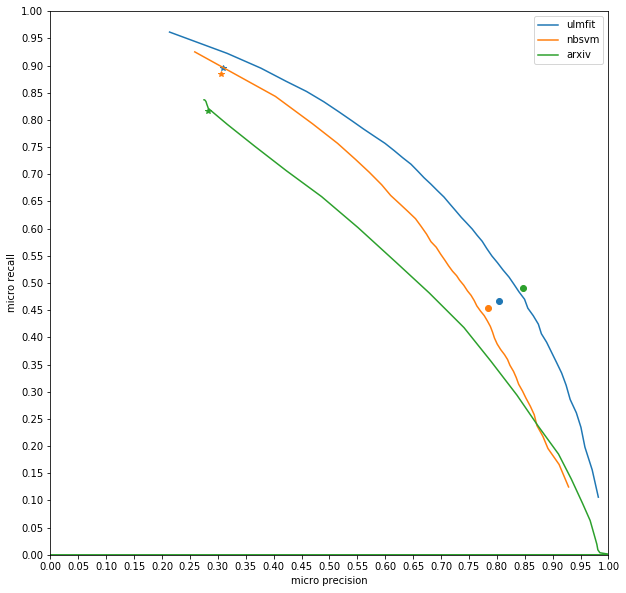

In [71]:
plot_pr("micro", ["ulmfit", "nbsvm", "arxiv"])

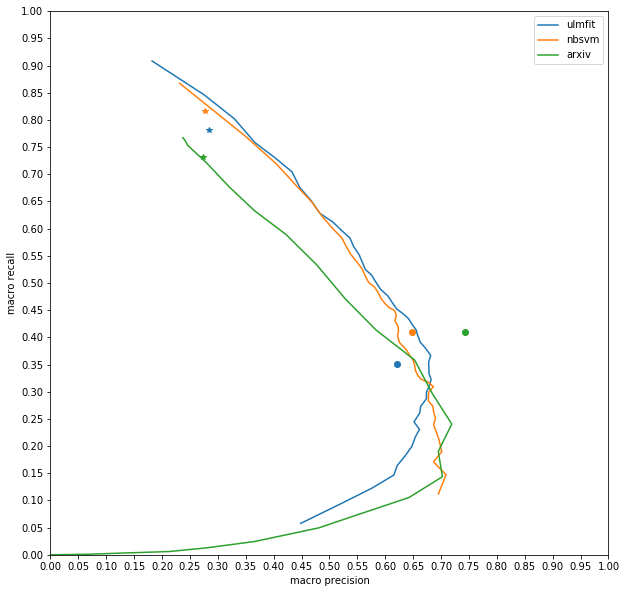

In [73]:
plot_pr("macro", ["ulmfit", "nbsvm", "arxiv"])

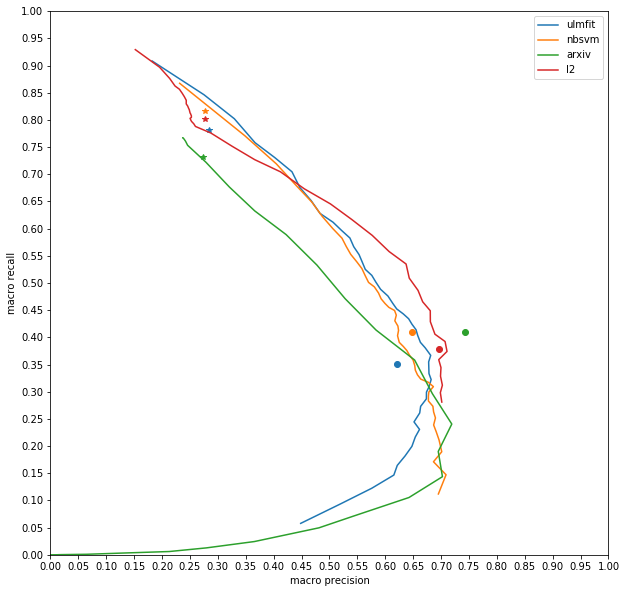

In [72]:
plot_pr("macro", ["ulmfit", "nbsvm", "arxiv", "l2"])

In [32]:
classes15 =\
    ['cs.LG', 'quant-ph', 'hep-ph', 'hep-th', 'cs.CV', 'stat.ML',
       'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'gr-qc', 'astro-ph.GA',
       'math.CO', 'math.AP', 'astro-ph.SR', 'math-ph', 'math.MP',
       'astro-ph.HE', 'astro-ph.CO', 'cond-mat.str-el', 'math.PR',
       'cs.IT', 'math.IT', 'math.OC', 'cond-mat.stat-mech', 'cs.AI',
       'physics.optics', 'cs.CL', 'math.AG', 'hep-ex', 'math.NA',
       'math.NT', 'nucl-th', 'math.DG', 'math.DS', 'cond-mat.soft',
       'astro-ph.EP', 'astro-ph.IM', 'math.FA', 'cs.CR',
       'cond-mat.supr-con', 'stat.ME', 'cs.DS', 'physics.flu-dyn',
       'cs.SY', 'physics.ins-det', 'math.RT', 'cond-mat.quant-gas',
       'cs.RO', 'cs.SI', 'math.CA', 'cs.NI', 'physics.comp-ph', 'cs.DC',
       'math.ST', 'stat.TH', 'eess.SP', 'nucl-ex', 'physics.chem-ph',
       'physics.soc-ph', 'physics.app-ph', 'math.GR', 'physics.atom-ph',
       'stat.AP', 'math.GT', 'cs.NE', 'cs.LO', 'cs.CY', 'hep-lat',
       'math.RA', 'physics.plasm-ph', 'math.CV', 'cs.IR',
       'physics.bio-ph', 'cond-mat.dis-nn', 'math.AT', 'cs.NA', 'cs.DM',
       'math.LO', 'eess.IV', 'cs.SE', 'cs.HC', 'math.QA', 'math.AC',
       'cs.GT', 'math.MG', 'q-bio.NC', 'math.OA', 'cs.CC', 'cs.SD',
       'q-bio.PE', 'stat.CO', 'math.SP', 'nlin.CD', 'q-bio.QM',
       'physics.data-an', 'eess.AS', 'cs.DB', 'cs.PL', 'nlin.SI',
       'math.CT', 'nlin.PS', 'cs.CG', 'physics.class-ph', 'math.SG',
       'cond-mat.other', 'physics.acc-ph', 'physics.gen-ph', 'eess.SY',
       'physics.med-ph', 'physics.space-ph', 'cs.MA', 'nlin.AO',
       'physics.geo-ph', 'cs.CE', 'cs.MM', 'physics.ao-ph', 'cs.FL',
       'math.KT', 'cs.DL', 'math.GN', 'physics.hist-ph', 'cs.GR', 'cs.ET',
       'q-bio.BM', 'cs.PF', 'q-fin.MF', 'math.HO', 'q-bio.MN',
       'physics.ed-ph', 'q-fin.EC', 'econ.EM', 'math.GM', 'cs.AR',
       'q-bio.TO', 'q-fin.ST', 'q-bio.GN', 'q-fin.GN', 'q-bio.CB',
       'cs.MS', 'physics.atm-clus', 'cs.SC', 'physics.pop-ph', 'q-fin.RM',
       'q-fin.CP', 'cs.OH', 'q-bio.SC', 'econ.GN', 'stat.OT', 'q-fin.PM',
       'q-fin.PR', 'q-fin.TR', 'econ.TH', 'nlin.CG', 'q-bio.OT', 'cs.OS',
       'cs.GL']

<BarContainer object of 176 artists>

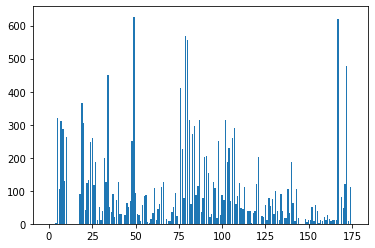

In [92]:
plt.bar(range(176), test_labels.sum(axis=0))

In [99]:
sum(test_labels.sum(axis=0) == 0)

21

In [98]:
stats_df.style.highlight_max()

,micro p,micro r,micro f1,macro p,macro r,macro f1,threshold,classifier
0,0.519106,0.795849,0.628356,0.397502,0.563681,0.451377,0.125,ulmfit
1,0.275219,0.837,0.414232,0.208787,0.675549,0.303395,0.125,arxiv
2,0.645424,0.696591,0.670032,0.476905,0.46244,0.449281,0.25,ulmfit
3,0.275219,0.837,0.414232,0.208787,0.675549,0.303395,0.25,arxiv
4,0.787475,0.539816,0.64054,0.546322,0.328543,0.390469,0.5,ulmfit
5,0.286006,0.815061,0.423429,0.219256,0.658933,0.310304,0.5,arxiv
6,0.888763,0.371894,0.524371,0.546353,0.207918,0.281957,0.75,ulmfit
7,0.924555,0.156952,0.26835,0.593208,0.107194,0.164018,0.75,arxiv
8,0.973022,0.128313,0.226727,0.397104,0.0634357,0.0996829,0.95,ulmfit
9,1,0.000177883,0.000355703,0.0113636,9.66324e-05,0.000191633,0.95,arxiv


In [99]:
from matplotlib import pyplot as plt
%matplotlib inline

In [100]:
stats_df[stats_df.classifier == "ulmfit"]["micro f1"]

0     0.628356
2     0.670032
4     0.640540
6     0.524371
8     0.226727
10    0.584556
Name: micro f1, dtype: float64

In [88]:
test_cm[10]

array([[9496,   14],
       [ 130,  134]])

In [87]:
current_arxiv_stats, current_arxiv_cm = get_test_stats(current_arxiv_preds, test_labels, "top-1")

In [89]:
current_arxiv_cm[10]

array([[9501,    9],
       [  85,  179]])

In [90]:
test_stats

{'micro p': 0.7966032330673215,
 'micro r': 0.46166617254669434,
 'micro f1': 0.5845564773452457,
 'macro p': 0.541691849804108,
 'macro r': 0.3007641376532098,
 'macro f1': 0.36635266221111384}

In [91]:
current_arxiv_stats

{'micro p': 0.8478616738285246,
 'micro r': 0.4913726652831307,
 'micro f1': 0.6221705018957167,
 'macro p': 0.6487122758800247,
 'macro r': 0.3617137034916534,
 'macro f1': 0.4428544074677056}

## Test with Full Text

This tests the ULMFiT classifier with full paper's text instead of title and abstract. Please not, however, that the classifier wasn't trained on full texts.

In [113]:
FULL_TEXT_PATH = Path("classifier_fulltext")

not_found = 0
for i, idx in enumerate(test_df.index):
    arxiv_id = test.iloc[i].arxiv_id
    arxiv_id.replace("/", "_")
    filename = FULL_TEXT_PATH / f"{arxiv_id}.txt"
    try:
        with filename.open() as f:
            test_df.loc[idx, "fulltext"] = f.read()
    except FileNotFoundError:
        test_df.loc[idx, "fulltext"] = test_df.loc[idx, "abstract"] + "\n" + test_df.loc[idx, "abstract"]
        not_found += 1

print(f"{not_found} files were not found")

14 files were not found


In [117]:
ft_test_tl = TextList.from_df(test_df, MODELS_PATH, cols=["title", "fulltext"], processor=processor)

learn.data.add_test(ft_test_tl)

In [118]:
ft_test_preds, _ = learn.get_preds(DatasetType.Test, ordered=True)

In [119]:
test_stats_all = []
for threshold in [0.125, 0.25, 0.5, 0.75, 0.95, "top-1"]:
    test_stats, test_cm = get_test_stats(test_preds, test_labels, threshold)
    test_stats['threshold'] = threshold
    test_stats['classifier'] = "ulmfit"
    test_stats_all.append(test_stats)

    test_stats, test_cm = get_test_stats(ft_test_preds, test_labels, threshold)
    test_stats['threshold'] = threshold
    test_stats['classifier'] = "ulmfit-fulltext"
    test_stats_all.append(test_stats)

    
    test_stats, test_cm = get_test_stats(current_arxiv_preds, test_labels, threshold)
    test_stats['threshold'] = threshold
    test_stats['classifier'] = "arxiv"
    test_stats_all.append(test_stats)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [120]:
stats_df = pd.DataFrame(test_stats_all)

stats_df.style.highlight_max()

,micro p,micro r,micro f1,macro p,macro r,macro f1,threshold,classifier
0,0.519106,0.795849,0.628356,0.397502,0.563681,0.451377,0.125,ulmfit
1,0.423888,0.683071,0.523137,0.339298,0.494873,0.38021,0.125,ulmfit-fulltext
2,0.275219,0.837,0.414232,0.208787,0.675549,0.303395,0.125,arxiv
3,0.645424,0.696591,0.670032,0.476905,0.46244,0.449281,0.25,ulmfit
4,0.558378,0.564305,0.561326,0.426493,0.389051,0.379359,0.25,ulmfit-fulltext
5,0.275219,0.837,0.414232,0.208787,0.675549,0.303395,0.25,arxiv
6,0.787475,0.539816,0.64054,0.546322,0.328543,0.390469,0.5,ulmfit
7,0.736624,0.4,0.518464,0.505254,0.256326,0.31673,0.5,ulmfit-fulltext
8,0.286006,0.815061,0.423429,0.219256,0.658933,0.310304,0.5,arxiv
9,0.888763,0.371894,0.524371,0.546353,0.207918,0.281957,0.75,ulmfit


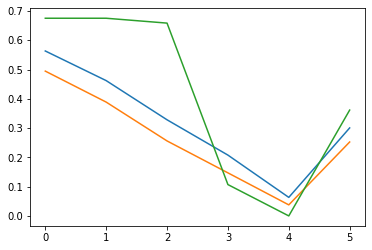

In [134]:
stat = "macro r"
x = stats_df[stats_df.classifier == "ulmfit"]["threshold"]
y1 = stats_df[stats_df.classifier == "ulmfit"][stat]
y2 = stats_df[stats_df.classifier == "ulmfit-fulltext"][stat]
y3 = stats_df[stats_df.classifier == "arxiv"][stat]
plt.plot(np.array([y1,y2,y3]).T);

0     0.628356
2     0.670032
4     0.640540
6     0.524371
8     0.226727
10    0.584556
Name: micro f1, dtype: float64

# Test Model

In [9]:
from fastai.text import *

BASE_DIR = Path("./models/ulmfit_baseline")
VOCAB_PATH = BASE_DIR / "data_lm_export_vocab.pkl"

processor = SPProcessor(sp_model=BASE_DIR / "tmp" / "spm.model", sp_vocab=BASE_DIR / "tmp" / "spm.vocab", n_cpus=4, mark_fields=True)
vocab = Vocab.load(VOCAB_PATH)


In [10]:
all_df = pd.DataFrame(train)

In [17]:
all_df.date = pd.to_datetime(all_df.date, infer_datetime_format=True)
# infer_datetime_format=True

In [18]:
train_df = all_df[all_df.date.dt.year<2020]
valid_df = all_df[~(all_df.date.dt.year<2020)]

In [19]:
valid_df.shape

(35005, 5)

In [20]:
models_path = DATA_PATH / "models"

In [21]:
text_cols = ["title", "abstract"]
valid_tl = TextList.from_df(valid_df, models_path, cols=text_cols, processor=processor)

In [22]:
train_tl = TextList.from_df(train_df, models_path, cols=text_cols, processor=processor)

In [23]:
# data_clas = ItemLists(models_path, train_tl, valid_tl)\
#     .label_from_df(["categories"], label_delim=" ")\
#     .databunch(bs=64)

In [24]:
# data_clas.save("data_clas_abs.pkl")

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BCEWithLogitsLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [25]:
# data_clas = load_data(models_path, "data_clas_abs.pkl")

In [26]:
learn = text_classifier_learner(data_clas, AWD_LSTM)

In [27]:
learn.load("arxiv_class_sp30k_1_1_6_abstracts.pkl")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1644347 items)
x: TextList
▁xxbos ▁xxfld ▁1 ▁xxmaj ▁stable ▁t ev ▁ - ▁xxmaj ▁black ▁xxmaj ▁hole ▁xxmaj ▁re m n ants ▁at ▁the ▁xxup ▁l hc : ▁xxmaj ▁discovery ▁through ▁di - jet ▁xxmaj ▁suppression , ▁mono - jet ▁xxmaj ▁emission ▁and ▁a ▁xxmaj ▁super sonic ▁xxmaj ▁b oom ▁in ▁the ▁ quar k - glu on ▁xxmaj ▁plasma ▁xxfld ▁2 ▁xxmaj ▁the ▁production ▁of ▁xxmaj ▁large ▁xxmaj ▁extra ▁xxmaj ▁dimension ▁xxup ▁( l x d ) ▁xxmaj ▁black ▁xxmaj ▁holes ▁( b hs ), ▁with ▁a ▁new , ▁fundamental ▁mass ▁scale ▁of ▁$ m _ f ▁= ▁1 $ ▁t ev , ▁has ▁been ▁predicted ▁to ▁occur ▁at ▁the ▁xxmaj ▁large ▁xxmaj ▁had ron ▁xxmaj ▁collider , ▁xxup ▁l hc , ▁with ▁the ▁for mid able ▁rate ▁of ▁$ 10 ^ 8 $ ▁per ▁year ▁in ▁p - p ▁collisions ▁at ▁full ▁energy , ▁14 ▁t ev , ▁and ▁at ▁full ▁lu min osity . ▁xxmaj ▁we ▁show ▁that ▁such ▁xxup ▁l x d - b h ▁formation ▁will ▁be ▁experimentally ▁observable ▁at ▁the ▁xxup ▁l hc ▁by ▁the ▁complete ▁disappearance ▁of ▁all ▁very ▁high ▁$

In [80]:
preds = learn.get_preds(ordered=True)

In [112]:
from sklearn.metrics import multilabel_confusion_matrix

In [163]:
def get_cm(preds, threshold=0.5):
    y_true = preds[1].cpu().numpy() > 0.5
    y_pred = preds[0].cpu().numpy() > threshold
    return multilabel_confusion_matrix(y_true, y_pred)

def get_test_cm(test_preds, test_labels, threshold=0.5):
    y_true = test_labels
    y_pred = test_preds.cpu().numpy() > threshold
    return multilabel_confusion_matrix(y_true, y_pred)
    

In [116]:
cm = get_cm(preds)

In [125]:
cm.mean(axis=0)

array([[34578.704545,    47.676136],
       [  186.948864,   191.670455]])

In [126]:
cm2 = [m for m in cm if m[0,0] != 35005]

In [135]:
def acc(cm):
    return (cm[0,0] + cm[1,1]) / cm.sum()

In [137]:
accs = [acc(m) for m in cm]

In [138]:
accs

[1.0,
 1.0,
 1.0,
 1.0,
 0.9955720611341237,
 0.9883445222111127,
 0.9950864162262534,
 0.9832595343522353,
 0.9882588201685474,
 0.9916583345236395,
 0.9852592486787601,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9936294815026425,
 0.9778317383230967,
 0.9780031424082274,
 0.9973146693329524,
 0.9942865304956435,
 0.9928581631195543,
 0.9845450649907156,
 0.9857448935866305,
 0.9966004856449079,
 0.9748035994857878,
 0.9985430652763891,
 0.9958863019568633,
 0.9965147836023425,
 0.9972003999428654,
 0.9902585344950722,
 0.9888587344665047,
 0.9792601056991859,
 0.9899442936723325,
 0.9959720039994286,
 0.9899442936723325,
 0.998428795886302,
 0.9936294815026425,
 0.9924296529067276,
 0.9974289387230396,
 0.997771746893301,
 0.9999714326524782,
 0.9980002856734752,
 0.9958577346093416,
 0.9911155549207256,
 0.9924296529067276,
 0.98317383230967,
 0.9293529495786316,
 0.9941151264105128,
 0.9953435223539494,
 0.9972003999428654,
 0.9992286816169119,
 0.9761748321668333,
 0.99148693043

In [136]:
acc(cm2[6])

0.9852592486787601

In [134]:
cm2[6]

array([[33927,    64],
       [  452,   562]])

In [122]:
cm[3]

array([[35005,     0],
       [    0,     0]])

In [90]:
data_clas.valid_ds[400]

(Text ▁xxbos ▁xxfld ▁1 ▁xxmaj ▁on ▁the ▁infinite ▁width ▁limit ▁of ▁neural ▁networks ▁with ▁a ▁standard ▁ parameterization ▁xxfld ▁2 ▁xxmaj ▁there ▁are ▁currently ▁two ▁ parameterization s ▁used ▁to ▁derive ▁fixed ▁kernels ▁corresponding ▁to ▁infinite ▁width ▁neural ▁networks , ▁the ▁xxup ▁n tk ▁( neural ▁xxmaj ▁tangent ▁xxmaj ▁kernel ) ▁ parameterization ▁and ▁the ▁naive ▁standard ▁ parameterization . ▁xxmaj ▁however , ▁the ▁extrapolation ▁of ▁both ▁of ▁these ▁ parameterization s ▁to ▁infinite ▁width ▁is ▁problematic . ▁xxmaj ▁the ▁standard ▁ parameterization ▁leads ▁to ▁a ▁divergent ▁neural ▁tangent ▁kernel ▁while ▁the ▁xxup ▁n tk ▁ parameterization ▁fails ▁to ▁capture ▁crucial ▁aspects ▁of ▁finite ▁width ▁networks ▁such ▁as : ▁the ▁dependence ▁of ▁training ▁dynamics ▁on ▁relative ▁layer ▁widths , ▁the ▁relative ▁training ▁dynamics ▁of ▁weights ▁and ▁biases , ▁and ▁a ▁non standard ▁learning ▁rate ▁scale . ▁xxmaj ▁here ▁we ▁propose ▁an ▁improved ▁extrapolation ▁of ▁the ▁standard ▁ par

In [92]:
y.c2i["cs.LG"]

49

In [93]:
y.c2i["stat.ML"]

172

In [ ]:
preds = [learn.predict()]

In [37]:
preds = [learn.predict(v) for v in valid_tl[::100][:10]]

In [79]:
preds[1][1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [39]:
x = preds[0]

In [43]:
type(x[0])

fastai.core.MultiCategory

In [44]:
y = x[0]

In [45]:
y

MultiCategory gr-qc

In [49]:
type(y)

fastai.core.MultiCategory

In [50]:
y.data

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [51]:
y.obj

['gr-qc']

In [52]:
y.raw

[76]

In [64]:
dir(valid_tl[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_tfms',
 'data',
 'show',
 'text']

In [65]:
valid_tl[0].data

array([   2,    4,   36,    5, ..., 3954,   18,  954,   12])

In [67]:
y = data_clas.valid_ds.y

In [235]:
test_tl[0]

Text ▁xxbos ▁xxfld ▁1 ▁xxmaj ▁en vel oping ▁bra nes ▁and ▁bra ne world ▁singularities ▁xxfld ▁2 ▁xxmaj ▁the ▁existence ▁of ▁envelope s ▁is ▁studied ▁for ▁systems ▁of ▁differential ▁equations ▁in ▁connection ▁with ▁the ▁method ▁of ▁asymptotic ▁splitting s ▁which ▁allows ▁to ▁determine ▁the ▁singularity ▁structure ▁of ▁the ▁solutions . ▁xxmaj ▁the ▁result ▁is ▁applied ▁to ▁bra ne world s ▁consisting ▁of ▁a ▁3 - bra ne ▁in ▁a ▁five - dimensional ▁bulk , ▁in ▁the ▁presence ▁of ▁an ▁analog ▁of ▁a ▁bulk ▁perfect ▁fluid ▁parametrizing ▁a ▁generic ▁class ▁of ▁bulk ▁matter . ▁xxmaj ▁we ▁find ▁that ▁all ▁flat ▁bra ne ▁solutions ▁suffer ▁from ▁a ▁finite ▁distance ▁singularity ▁contrary ▁to ▁previous ▁claims . ▁xxmaj ▁we ▁then ▁study ▁the ▁possibility ▁of ▁avoiding ▁finite ▁distance ▁singularities ▁by ▁cutting ▁the ▁bulk ▁and ▁ glu ing ▁regular ▁solutions ▁at ▁the ▁position ▁of ▁the ▁bra ne . ▁xxmaj ▁further ▁imposing ▁physical ▁conditions ▁such ▁as ▁finite ▁xxmaj ▁ planck ▁mass ▁on ▁the ▁bra ne ▁

In [222]:
test_tl[0].data

array([  2,   4,  36,   5, ...,  11,  30, 210,  12])

In [72]:
y.c2i['math.AP']

84

In [73]:
y.classes[84]

'math.AP'

In [241]:
test_df = all_df[all_df.arxiv_id.isin(test_no_version)]

In [248]:
learn.data.test_ds[0]

(Text ▁xxbos ▁xxfld ▁1 ▁xxmaj ▁en vel oping ▁bra nes ▁and ▁bra ne world ▁singularities ▁xxfld ▁2 ▁xxmaj ▁the ▁existence ▁of ▁envelope s ▁is ▁studied ▁for ▁systems ▁of ▁differential ▁equations ▁in ▁connection ▁with ▁the ▁method ▁of ▁asymptotic ▁splitting s ▁which ▁allows ▁to ▁determine ▁the ▁singularity ▁structure ▁of ▁the ▁solutions . ▁xxmaj ▁the ▁result ▁is ▁applied ▁to ▁bra ne world s ▁consisting ▁of ▁a ▁3 - bra ne ▁in ▁a ▁five - dimensional ▁bulk , ▁in ▁the ▁presence ▁of ▁an ▁analog ▁of ▁a ▁bulk ▁perfect ▁fluid ▁parametrizing ▁a ▁generic ▁class ▁of ▁bulk ▁matter . ▁xxmaj ▁we ▁find ▁that ▁all ▁flat ▁bra ne ▁solutions ▁suffer ▁from ▁a ▁finite ▁distance ▁singularity ▁contrary ▁to ▁previous ▁claims . ▁xxmaj ▁we ▁then ▁study ▁the ▁possibility ▁of ▁avoiding ▁finite ▁distance ▁singularities ▁by ▁cutting ▁the ▁bulk ▁and ▁ glu ing ▁regular ▁solutions ▁at ▁the ▁position ▁of ▁the ▁bra ne . ▁xxmaj ▁further ▁imposing ▁physical ▁conditions ▁such ▁as ▁finite ▁xxmaj ▁ planck ▁mass ▁on ▁the ▁bra ne 

In [249]:
test_preds, _ = learn.get_preds(DatasetType.Test, ordered=True)

In [157]:
test_df.head()

,arxiv_id,categories,date,title,abstract
498165,1406.0611,hep-th gr-qc,2014-06-03 07:50:04+00:00,Enveloping branes and braneworld singularities,The existence of envelopes is studied for sy...
498168,1410.1071,cond-mat.mtrl-sci cond-mat.dis-nn physics.comp-ph,2014-10-04 18:03:06+00:00,Inverse simulated annealing: Improvements and ...,An improved inverse simulated annealing meth...
498273,1212.5904,math.AG,2012-12-24 12:25:31+00:00,Mirror Transitions and the Batyrev-Borisov con...,We consider examples of extremal transitions...
498657,1411.3956,q-bio.NC,2014-11-14 16:24:42+00:00,Self-organization of microcircuits in networks...,The synaptic connectivity of cortical networ...
499313,1408.2094,math.HO,2014-08-09 13:25:55+00:00,Une nouvelle d\'emonstration d'irrationalit\'e...,To account for the first proof of existence ...


In [250]:
def get_test_labels(test_df, c2i):
    out = np.zeros((len(test_df), len(c2i)), dtype=np.int8)
    for i, (_, row) in enumerate(test_df.iterrows()):
        for x in row.categories.split(' '):
            out[i, c2i[x]] = 1
    return out

In [251]:
test_labels = get_test_labels(test_df, data_clas.valid_ds.y.c2i)

In [252]:
test_cm = get_test_cm(test_preds, test_labels)

In [253]:
test_cm[0]

array([[10315,     0],
       [    0,     0]])

In [254]:
test_accs = [acc(m) for m in test_cm]

In [263]:
data_clas.valid_dl.y.c2i['math.AG']

83

In [264]:
test_cm[83]

array([[9980,   44],
       [  82,  209]])

In [ ]:
def p(cm):
    tp = 

In [255]:
test_accs

[1.0,
 1.0,
 1.0,
 1.0,
 0.9926320891904993,
 0.9803199224430441,
 0.9953465826466311,
 0.9838099854580707,
 0.9840038778477945,
 0.9919534658264663,
 0.9866214251090645,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9936015511391177,
 0.9778962675714978,
 0.9815802229762481,
 0.9956374212312167,
 0.9939893359185652,
 0.9933107125545322,
 0.9822588463402812,
 0.9833252544837615,
 0.9937954435288415,
 0.9829374697043141,
 0.998739699466796,
 0.9959282598158022,
 0.998739699466796,
 0.9974793989335918,
 0.9942801745031508,
 0.9940862821134271,
 0.9850702859912749,
 0.9950557440620456,
 0.9972855065438682,
 0.9936015511391177,
 0.9986427532719341,
 0.9925351429956374,
 0.9909840038778478,
 0.9969946679592826,
 0.9981580222976248,
 1.0,
 0.9978671837130393,
 0.9959282598158022,
 0.9961221522055259,
 0.9959282598158022,
 0.9880756180319923,
 0.9639360155113912,
 0.9934076587493941,
 0.9966068831798351,
 0.9976732913233156,
 0.9991274842462433,
 0.9936984973339796,
 0.9927290353853612,
 0.994

In [256]:
test_cm2 = [m for m in test_cm if m[0,0] != 10315]

In [257]:
test_cm3 = [m for m in test_cm if m[1,1] > 0]

In [265]:
from sklearn.metrics import precision_score, recall_score

In [329]:
def get_test_stats(test_preds, test_labels, threshold=0.5):
    y_true = test_labels
    if threshold <= 1.0:
        y_pred = test_preds.cpu().numpy() > threshold
    else:
        idx = test_preds.cpu().argmax(1, keepdim=True)
        one_hot = torch.FloatTensor(probs.shape)
        y_pred = test_preds.cpu().numpy().argmax()
    return precision_score(y_true, y_pred, average='micro'), recall_score(y_true, y_pred, average='micro')

In [330]:
get_test_stats(test_preds, test_labels, 0.5)

(0.7869817646577807, 0.5383754754978742)

In [331]:
get_test_stats(test_preds, test_labels, 0.75)

(0.889008186820561, 0.3705526963526516)

In [332]:
get_test_stats(test_preds, test_labels, 0.25)

(0.6451395022600925, 0.6946184828820765)

In [339]:
[(x['category'], x['logodds']) for x in eval(test.output.iloc[0])['classifier']]

[('physics.optics', '1.1'),
 ('physics.app-ph', '0.53'),
 ('cond-mat.mes-hall', '0.25'),
 ('quant-ph', '0.13')]

In [340]:
from scipy.special import sigmoid

ImportError: cannot import name 'sigmoid' from 'scipy.special' (/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/scipy/special/__init__.py)

In [ ]:
their_test_preds = 

In [275]:
test_df.categories.str.contains("math.AG").sum()

291

In [291]:
test_no_version

0       1907.06506
1       1902.03608
2       1808.08508
3       1802.10202
4       1701.06664
           ...    
9995    1603.01701
9996    1507.04128
9997     1411.1028
9998    2001.00745
9999    1908.02441
Name: arxiv_id, Length: 10000, dtype: object

In [303]:
test_full = test.copy(True)

In [304]:
test_full["no_version"] = test_no_version

In [305]:
test_full.tail()

,arxiv_id,tags,output,no_version
9995,1603.01701v1,cond-mat.mes-hall quant-ph,"{""flags"":{},""classifier"":[{""topwords"":[{""fidel...",1603.01701
9996,1507.04128v1,physics.class-ph cond-mat.mtrl-sci,"{""flags"":{},""classifier"":[{""topwords"":[{""hall ...",1507.04128
9997,1411.1028v1,math.GR math.GT,"{""flags"":{},""classifier"":[{""topwords"":[{""braid...",1411.1028
9998,2001.00745v1,cs.LG stat.ML,"{""flags"":{},""classifier"":[{""topwords"":[{""blur""...",2001.00745
9999,1908.02441v1,cs.LG cs.CV stat.ML,"{""flags"":{},""classifier"":[{""topwords"":[{""subsp...",1908.02441


In [309]:
mm = test_full.merge(test_df, left_on="no_version", right_on="arxiv_id")

In [318]:
sum(test_no_version.duplicated())

53

In [326]:
test_df.duplicated()

498165     False
498168     False
498273     False
498657     False
499313     False
           ...  
1679126    False
1679169    False
1679207    False
1679231    False
1679268    False
Length: 10315, dtype: bool

In [328]:
test_no_version.isin(test_df.arxiv_id).sum()

9827